In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['test_simplified.csv', 'train_simplified']


In [2]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

# Have you installed your own package in Kernels yet? 
# If you need to, you can use the "Settings" bar on the right to install `simplification`
from simplification.cutil import simplify_coords

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data = pd.read_csv('input/train_simplified/cat.csv',
                   index_col='key_id',
                   nrows=100)
data.head()

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
5201136883597312,VE,"[[[130, 113, 99, 109, 76, 64, 55, 48, 48, 51, ...",True,2017-03-02 23:25:10.074530,cat
4647694628814848,BR,"[[[222, 196, 176, 173, 179, 191, 233, 251, 255...",True,2017-03-26 18:43:54.780830,cat
6411036099870720,RO,"[[[65, 71, 74, 68, 70, 65, 65], [64, 67, 72, 7...",True,2017-03-18 09:36:08.290570,cat
6196755135725568,US,"[[[148, 127, 119, 80, 60, 53, 48, 49, 56, 67, ...",True,2017-01-25 16:05:51.963360,cat
4597292839469056,ID,"[[[91, 77, 74, 75, 90, 116, 134, 148, 164, 165...",True,2017-01-29 02:42:16.318460,cat


In [4]:
data['word'] = data['word'].replace(' ', '_', regex=True)
data.head()

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
5201136883597312,VE,"[[[130, 113, 99, 109, 76, 64, 55, 48, 48, 51, ...",True,2017-03-02 23:25:10.074530,cat
4647694628814848,BR,"[[[222, 196, 176, 173, 179, 191, 233, 251, 255...",True,2017-03-26 18:43:54.780830,cat
6411036099870720,RO,"[[[65, 71, 74, 68, 70, 65, 65], [64, 67, 72, 7...",True,2017-03-18 09:36:08.290570,cat
6196755135725568,US,"[[[148, 127, 119, 80, 60, 53, 48, 49, 56, 67, ...",True,2017-01-25 16:05:51.963360,cat
4597292839469056,ID,"[[[91, 77, 74, 75, 90, 116, 134, 148, 164, 165...",True,2017-01-29 02:42:16.318460,cat


In [49]:
test_raw = pd.read_csv('input/test_simplified.csv', index_col='key_id') #first ten drawings in test data
first_ten_ids = test_raw.iloc[:10].index
raw_images = [ast.literal_eval(lst) for lst in test_raw.loc[first_ten_ids, 'drawing'].values]

In [50]:
def resample(x, y, spacing=1.0):
    output = []
    n = len(x)
    px = x[0]
    py = y[0]
    cumlen = 0
    pcumlen = 0
    offset = 0
    for i in range(1, n):
        cx = x[i]
        cy = y[i]
        dx = cx - px
        dy = cy - py
        curlen = math.sqrt(dx*dx + dy*dy)
        cumlen += curlen
        while offset < cumlen:
            t = (offset - pcumlen) / curlen
            invt = 1 - t
            tx = px * invt + cx * t
            ty = py * invt + cy * t
            output.append((tx, ty))
            offset += spacing
        pcumlen = cumlen
        px = cx
        py = cy
    output.append((x[-1], y[-1]))
    return output
  
def normalize_resample_simplify(strokes, epsilon=1.0, resample_spacing=1.0):
    if len(strokes) == 0:
        raise ValueError('empty image')

    # find min and max
    amin = None
    amax = None
    for x, y in strokes:
        cur_min = [np.min(x), np.min(y)]
        cur_max = [np.max(x), np.max(y)]
        amin = cur_min if amin is None else np.min([amin, cur_min], axis=0)
        amax = cur_max if amax is None else np.max([amax, cur_max], axis=0)

    # drop any drawings that are linear along one axis
    arange = np.array(amax) - np.array(amin)
    if np.min(arange) == 0:
        raise ValueError('bad range of values')

    arange = np.max(arange)
    output = []
    for x, y in strokes:
        xy = np.array([x, y], dtype=float).T
        xy -= amin
        xy *= 255.
        xy /= arange
        resampled = resample(xy[:, 0], xy[:, 1], resample_spacing)
        simplified = simplify_coords(resampled, epsilon)
        xy = np.around(simplified).astype(np.uint8)
        output.append(xy.T.tolist())

    return output

In [51]:
simplified_drawings = []
for drawing in raw_images:
    simplified_drawing = normalize_resample_simplify(drawing)
    simplified_drawings.append(simplified_drawing)

In [52]:
raw_images[0][1][1]

[117, 117, 134, 155, 177, 180, 176, 160, 148, 129, 127]

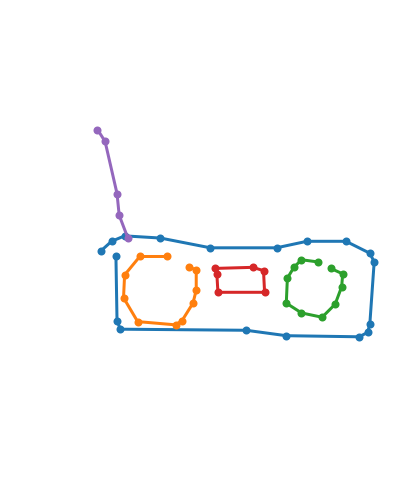

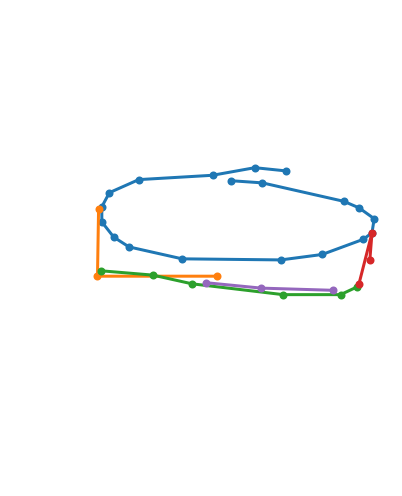

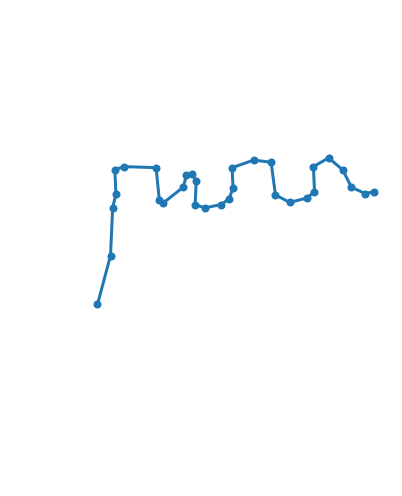

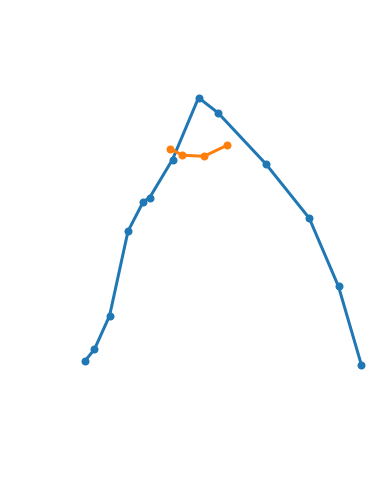

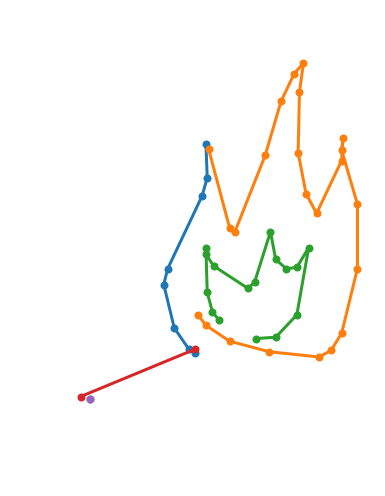

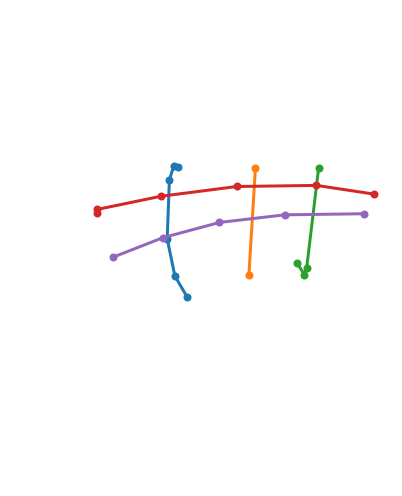

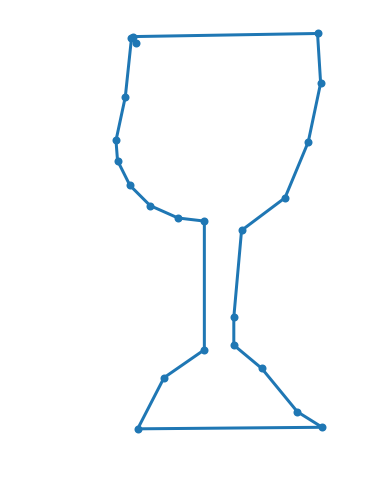

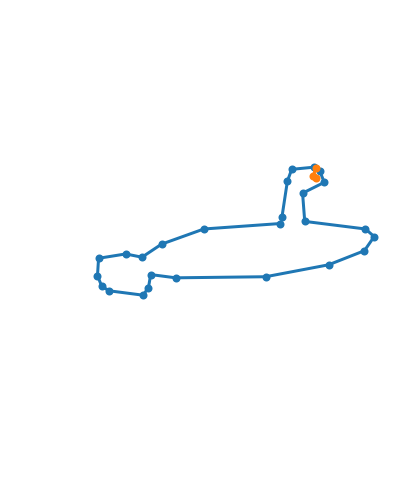

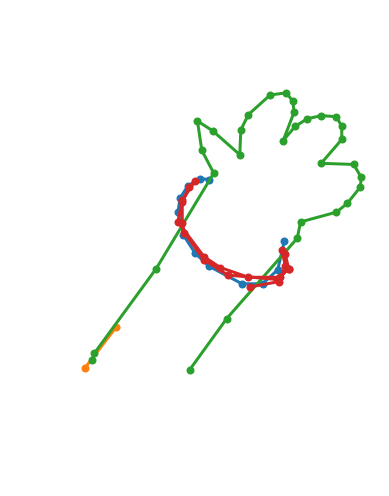

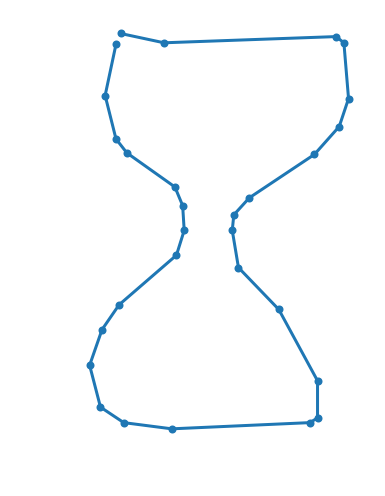

In [53]:
for index, raw_drawing in enumerate(raw_images, 0):

    for x,y in simplified_drawings[index]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()  